In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn
rcParams['figure.figsize'] = 20, 12


In [2]:
import h2o
    
# Start H2O on your local machine
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_92"; Java(TM) SE Runtime Environment (build 1.8.0_92-b14); Java HotSpot(TM) 64-Bit Server VM (build 25.92-b14, mixed mode)
  Starting server from /usr/local/h2o_jar/h2o.jar
  Ice root: /var/folders/25/v95_ldjj7d5ccs481hyd5svw8qd4n_/T/tmpewG4O9
  JVM stdout: /var/folders/25/v95_ldjj7d5ccs481hyd5svw8qd4n_/T/tmpewG4O9/h2o_spacagi001_started_from_python.out
  JVM stderr: /var/folders/25/v95_ldjj7d5ccs481hyd5svw8qd4n_/T/tmpewG4O9/h2o_spacagi001_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


In [5]:
ecg_data = h2o.import_file("http://h2o-public-test-data.s3.amazonaws.com/smalldata/anomaly/ecg_discord_test.csv")

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [6]:
ecg_data.shape

(23, 210)

In [7]:
ecg_data.types

{u'C1': u'real',
 u'C10': u'real',
 u'C100': u'real',
 u'C101': u'real',
 u'C102': u'real',
 u'C103': u'real',
 u'C104': u'real',
 u'C105': u'real',
 u'C106': u'real',
 u'C107': u'real',
 u'C108': u'real',
 u'C109': u'real',
 u'C11': u'real',
 u'C110': u'real',
 u'C111': u'real',
 u'C112': u'real',
 u'C113': u'real',
 u'C114': u'real',
 u'C115': u'real',
 u'C116': u'real',
 u'C117': u'real',
 u'C118': u'real',
 u'C119': u'real',
 u'C12': u'real',
 u'C120': u'real',
 u'C121': u'real',
 u'C122': u'real',
 u'C123': u'real',
 u'C124': u'real',
 u'C125': u'real',
 u'C126': u'real',
 u'C127': u'real',
 u'C128': u'real',
 u'C129': u'real',
 u'C13': u'real',
 u'C130': u'real',
 u'C131': u'real',
 u'C132': u'real',
 u'C133': u'real',
 u'C134': u'real',
 u'C135': u'real',
 u'C136': u'real',
 u'C137': u'real',
 u'C138': u'real',
 u'C139': u'real',
 u'C14': u'real',
 u'C140': u'real',
 u'C141': u'real',
 u'C142': u'real',
 u'C143': u'real',
 u'C144': u'real',
 u'C145': u'real',
 u'C146': u'real',


In [8]:
train_ecg = ecg_data[:20:, :]
test_ecg = ecg_data[:23, :]

In [9]:
def plot_stacked_time_series(df, title):
    stacked = df.stack()
    stacked = stacked.reset_index()
    total = [data[0].values for name,data in stacked.groupby('level_0')]
    pd.DataFrame({idx:pos for idx,pos in enumerate(total)}, index=data['level_1']).plot(title=title)
    plt.legend(bbox_to_anchor=(1.05, 1))

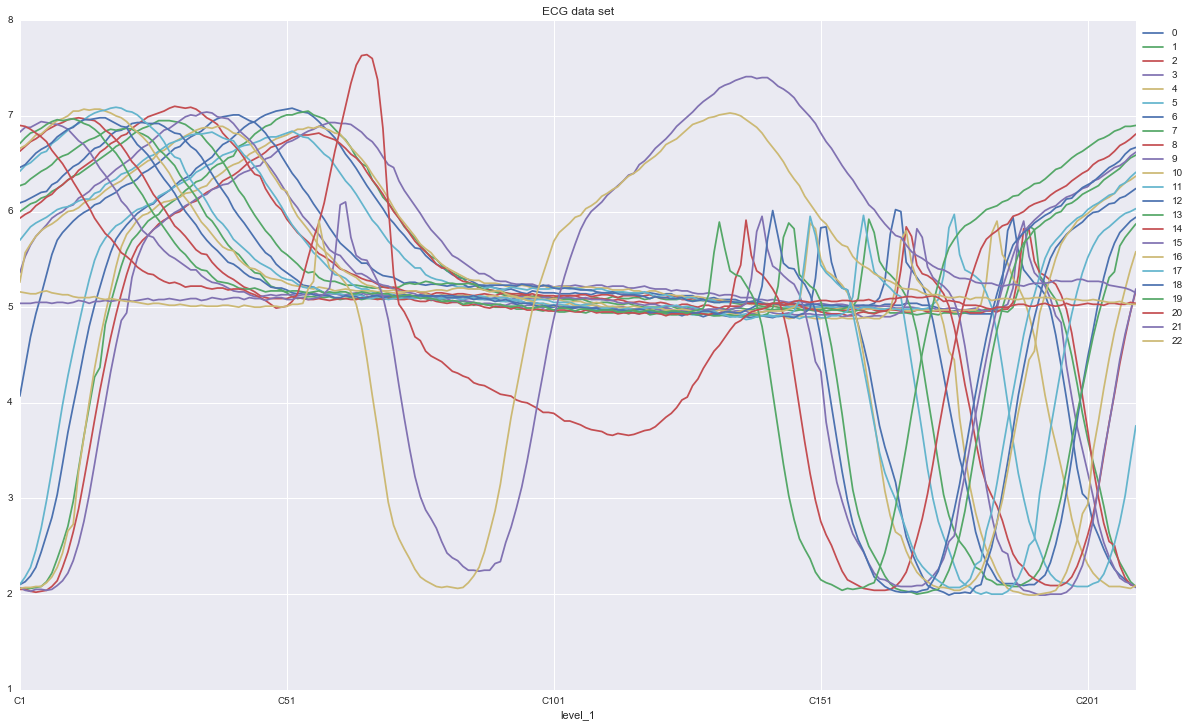

In [12]:
plot_stacked_time_series(ecg_data.as_data_frame(), "ECG data set")

In [16]:
from matplotlib import cm

def plot_bidimensional(model, test, recon_error, layer, title):

    bidimensional_data = model.deepfeatures(test, layer).cbind(recon_error).as_data_frame()

    cmap = cm.get_cmap('Spectral')

    fig, ax = plt.subplots()
    bidimensional_data.plot(kind='scatter', 
                            x='DF.L{}.C1'.format(layer+1), 
                            y='DF.L{}.C2'.format(layer+1), 
                            s = 500,
                            c = 'Reconstruction.MSE',
                            title = title,
                            ax = ax,
                            colormap=cmap)
    layer_column = 'DF.L{}.C'.format(layer + 1)
    columns = [layer_column + '1', layer_column + '2']
    for k, v in bidimensional_data[columns].iterrows():
        ax.annotate(k, v, size=20, verticalalignment='bottom', horizontalalignment='left')
    fig.canvas.draw()


In [17]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
seed = 13

model = H2OAutoEncoderEstimator(
    activation="Tanh",
    hidden=[50,20, 2, 20, 50],
    epochs=100,
    #sparse=True,
    #l1=1e-5,
    seed=seed,
    reproducible=True)

deeplearning Model Build progress: |██████████████████████████████████████████████████████████| 100%
deepfeatures progress: |██████████████████████████████████████████████████████████████████████| 100%


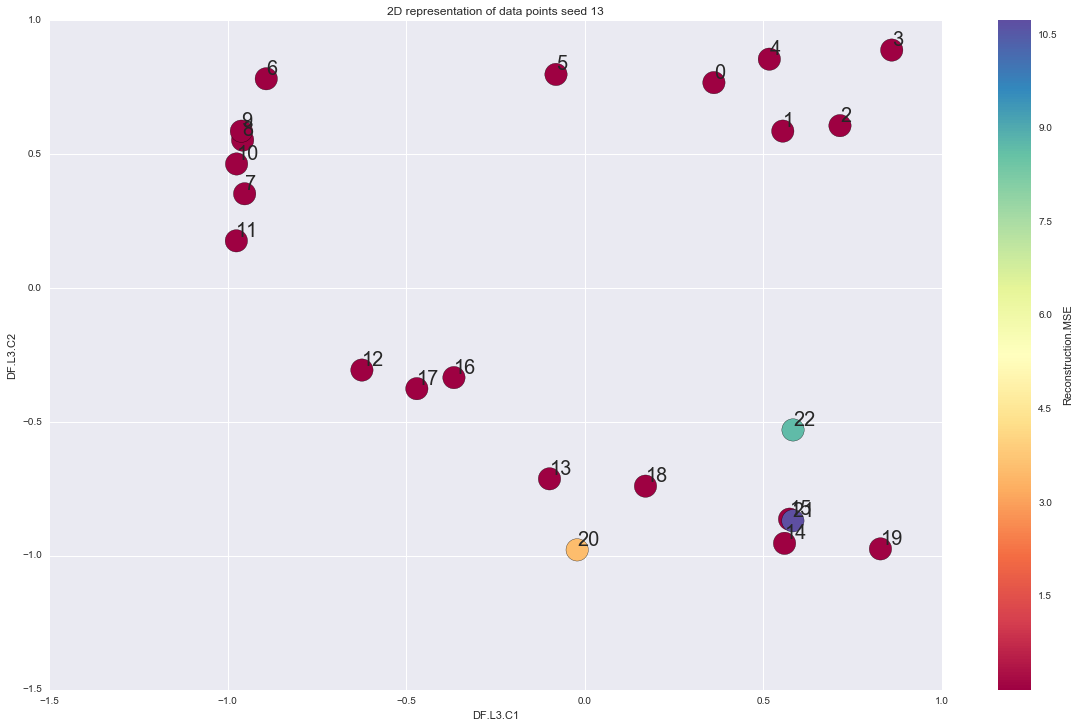

In [33]:
model.train(
    x=train_ecg.names,
    training_frame=train_ecg
)

recon_error = model.anomaly(test_ecg)
plot_bidimensional(model, test_ecg, recon_error, 2, "2D representation of data points seed {}".format(seed))

deeplearning prediction progress: |███████████████████████████████████████████████████████████| 100%


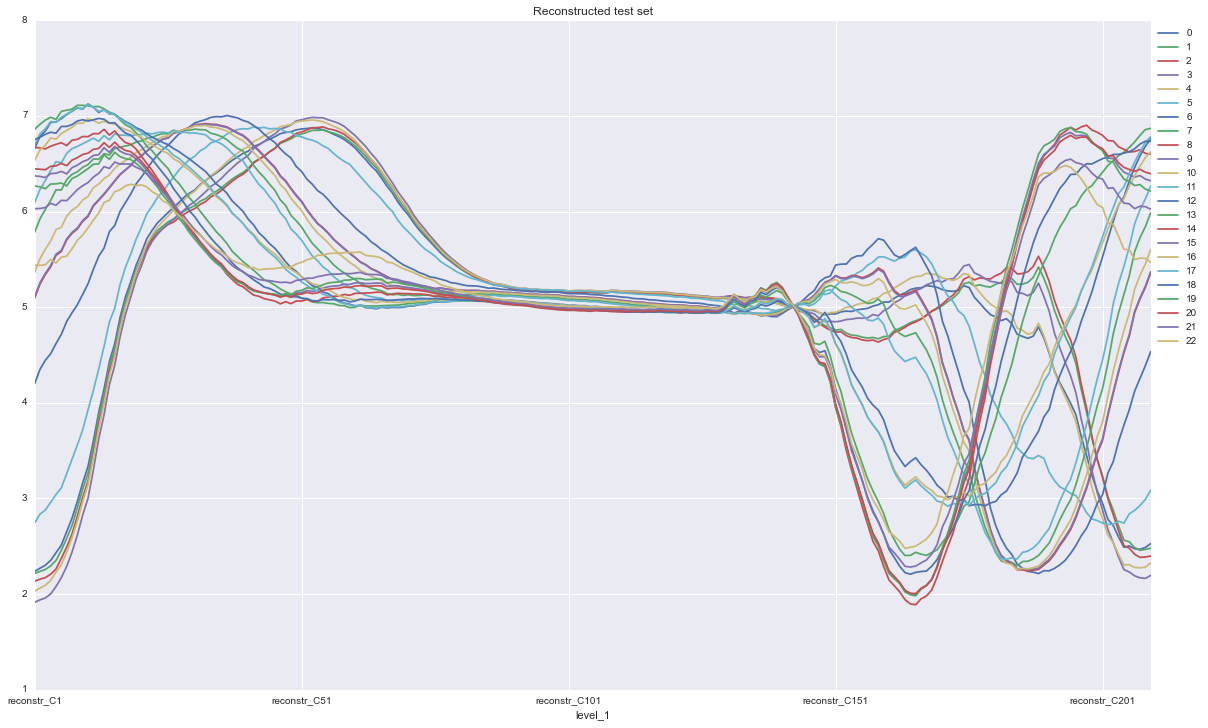

In [65]:
plot_stacked_time_series(model.predict(ecg_data).as_data_frame(), "Reconstructed test set")

In [27]:
model

Model Details
H2OAutoEncoderEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1474567448615_4
Status of Neuron Layers: auto-encoder, gaussian distribution, Quadratic loss, 23,432 weights/biases, 309.8 KB, 520 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,210,Input,0.0,,,,,,,,,
,2,50,Tanh,0.0,0.0,0.0,0.0083766,0.0068800,0.0,-0.0009833,0.0915424,-0.0043664,0.0592978
,3,20,Tanh,0.0,0.0,0.0,0.0039011,0.0030240,0.0,0.0025592,0.1660135,-0.0067650,0.0246019
,4,2,Tanh,0.0,0.0,0.0,0.0010923,0.0005762,0.0,0.0169021,0.2919058,-0.0126725,0.0182579
,5,20,Tanh,0.0,0.0,0.0,0.0020139,0.0008689,0.0,-0.0048597,0.3444163,0.0035793,0.0343975
,6,50,Tanh,0.0,0.0,0.0,0.0111054,0.0126430,0.0,0.0058093,0.1723008,-0.0078679,0.0406936
,7,210,Tanh,,0.0,0.0,0.0133532,0.0077565,0.0,-0.0000553,0.0944167,-0.0029387,0.0198362




ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 0.0171356901952
RMSE: 0.130903362047
Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse
,2016-09-22 20:28:02,0.006 sec,0 rows/sec,0.0,0,0.0,0.3293355,0.1084619
,2016-09-22 20:28:02,0.018 sec,1818 rows/sec,1.0,1,20.0,0.2425447,0.0588280
,2016-09-22 20:28:02,0.032 sec,1739 rows/sec,2.0,2,40.0,0.2142921,0.0459211
,2016-09-22 20:28:02,0.043 sec,1818 rows/sec,3.0,3,60.0,0.1843806,0.0339962
,2016-09-22 20:28:02,0.054 sec,1860 rows/sec,4.0,4,80.0,0.1566836,0.0245497
---,---,---,---,---,---,---,---,---
,2016-09-22 20:28:02,0.244 sec,2115 rows/sec,22.0,22,440.0,0.1327208,0.0176148
,2016-09-22 20:28:02,0.254 sec,2129 rows/sec,23.0,23,460.0,0.1391618,0.0193660
,2016-09-22 20:28:02,0.265 sec,2133 rows/sec,24.0,24,480.0,0.1347070,0.0181460
,2016-09-22 20:28:02,0.274 sec,2145 rows/sec,25.0,25,500.0,0.1322332,0.0174856



See the whole table with table.as_data_frame()


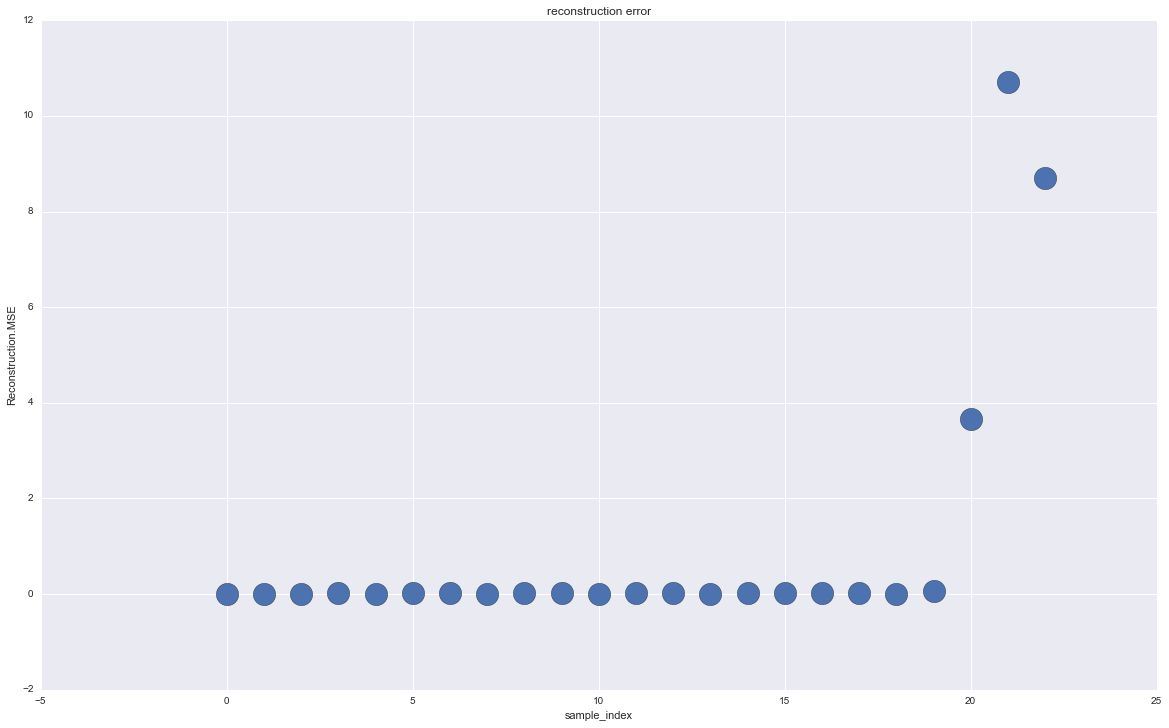

In [66]:
plt.figure()
df=recon_error.as_data_frame(True)
df["sample_index"]=df.index
df.plot(kind="scatter", x="sample_index", y="Reconstruction.MSE", 
        title = "reconstruction error", s = 500)

In [95]:
len(recon_error)

23

In [278]:
anomaly_model.deepfeatures(train_ecg, 1).as_data_frame()#.plot(kind='scatter', x='DF.L2.C1', y='DF.L2.C2')

deepfeatures progress: |██████████████████████████████████████████████████████████████████████| 100%


,DF.L2.C1,DF.L2.C2
0,-0.172611,-0.621852
1,-0.085223,-0.471084
2,-0.034723,-0.534609
3,-0.076254,-0.761788
4,-0.042983,-0.716959
5,0.174157,-0.595596
6,0.300446,-0.056162
7,0.158602,0.507489
8,0.140128,0.407228
9,0.324051,0.507595


Anomaly detection using compressed representation

deeplearning Model Build progress: |██████████████████████████████████████████████████████████| 100%
deepfeatures progress: |██████████████████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████████████████████████| 100%
deepfeatures progress: |██████████████████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████████████████████████| 100%
deepfeatures progress: |██████████████████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████████████████████████| 100%
deepfeatures progress: |██████████████████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████████████████████████| 100%
deepfeatures progress: |███████████████████████████████████████████████████████████████████

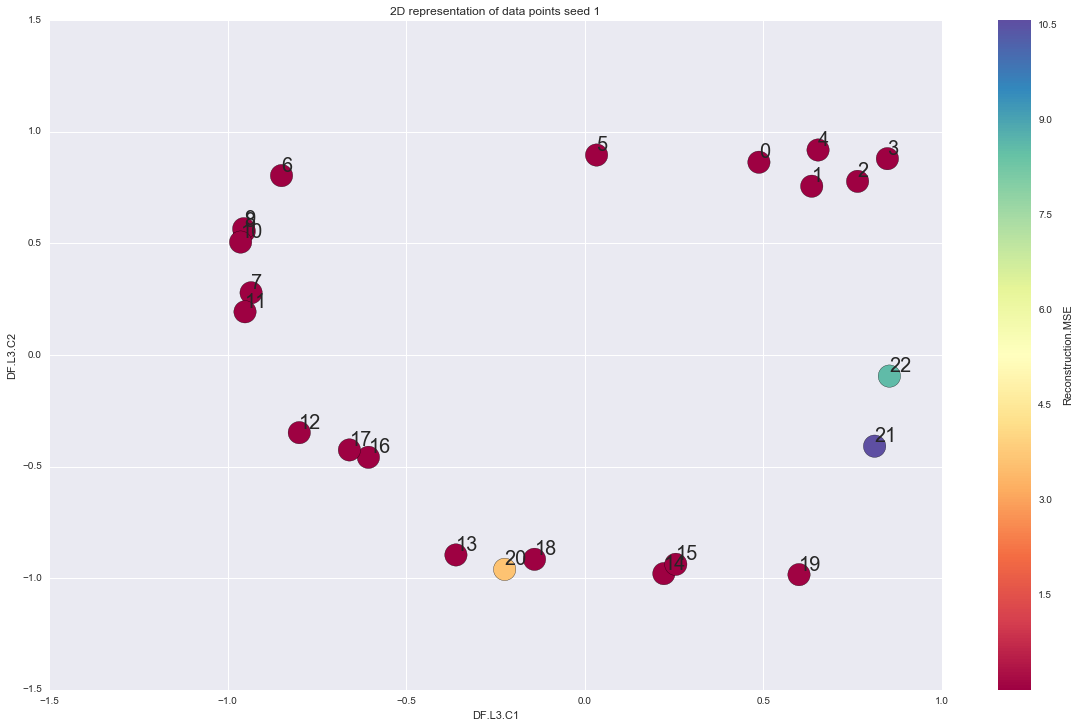

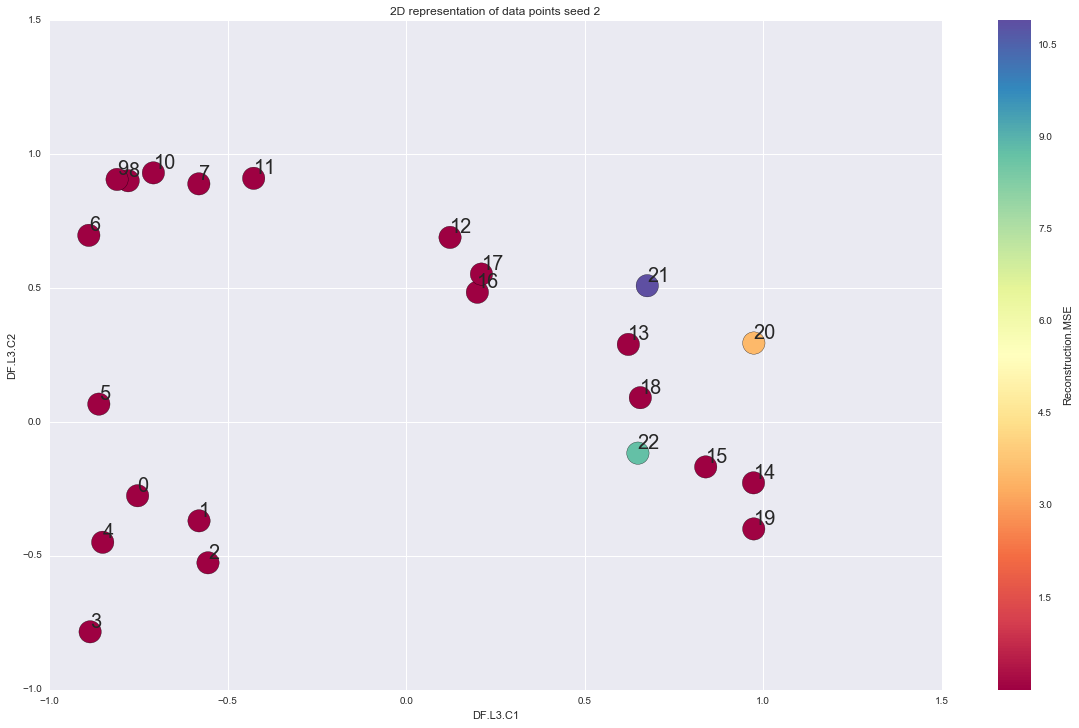

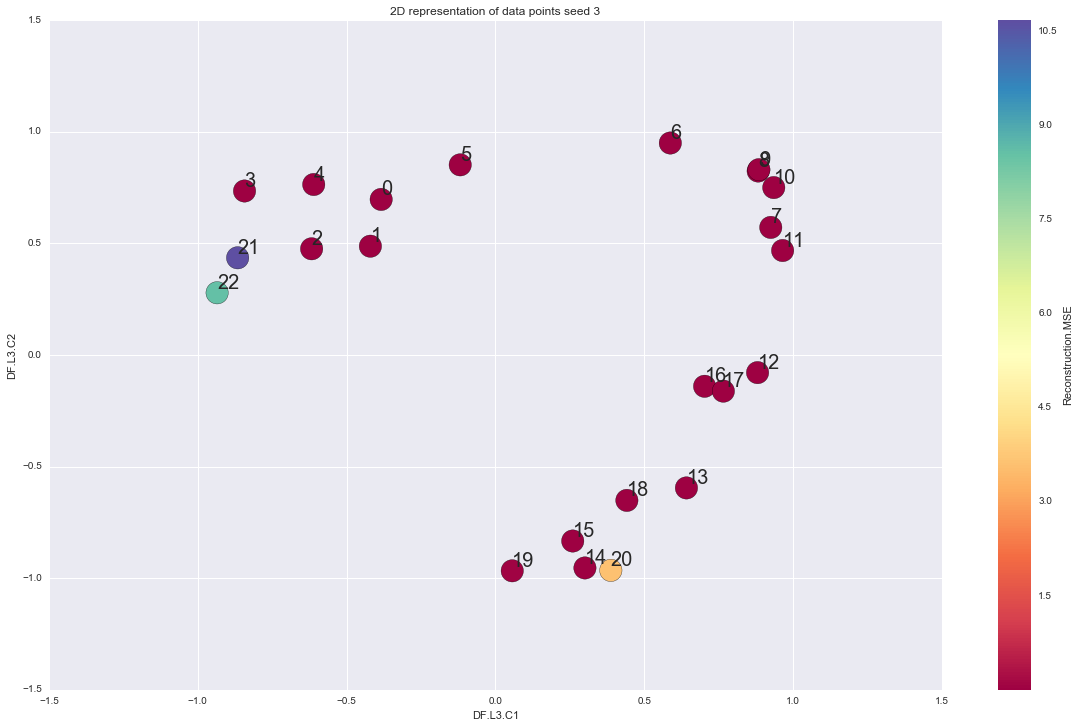

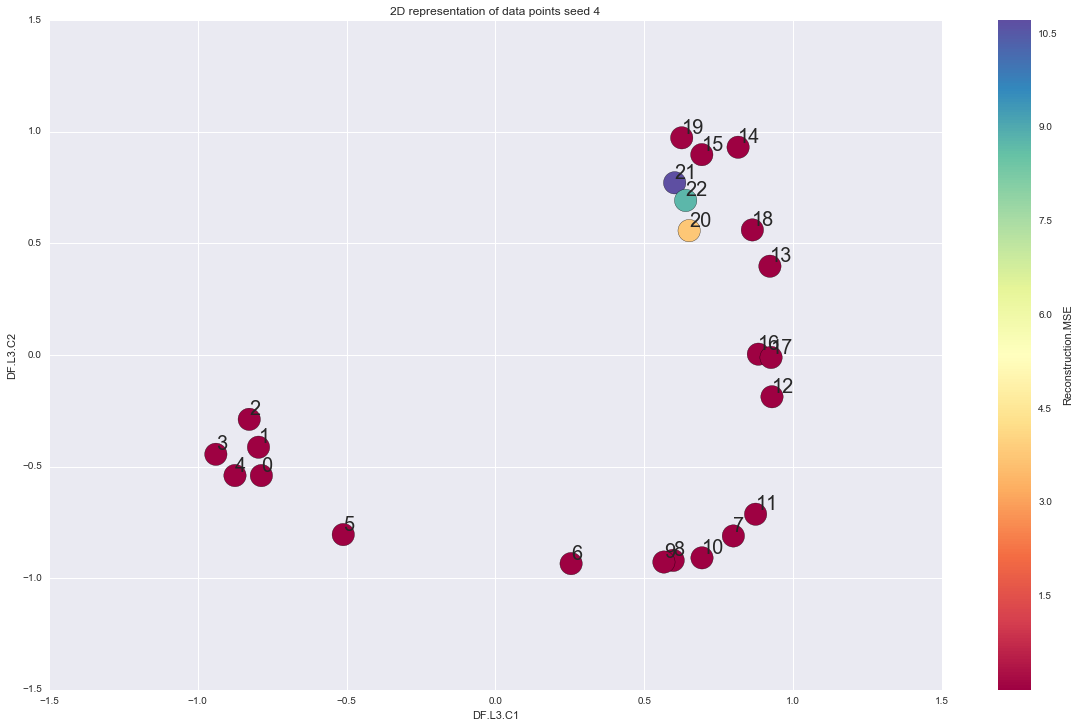

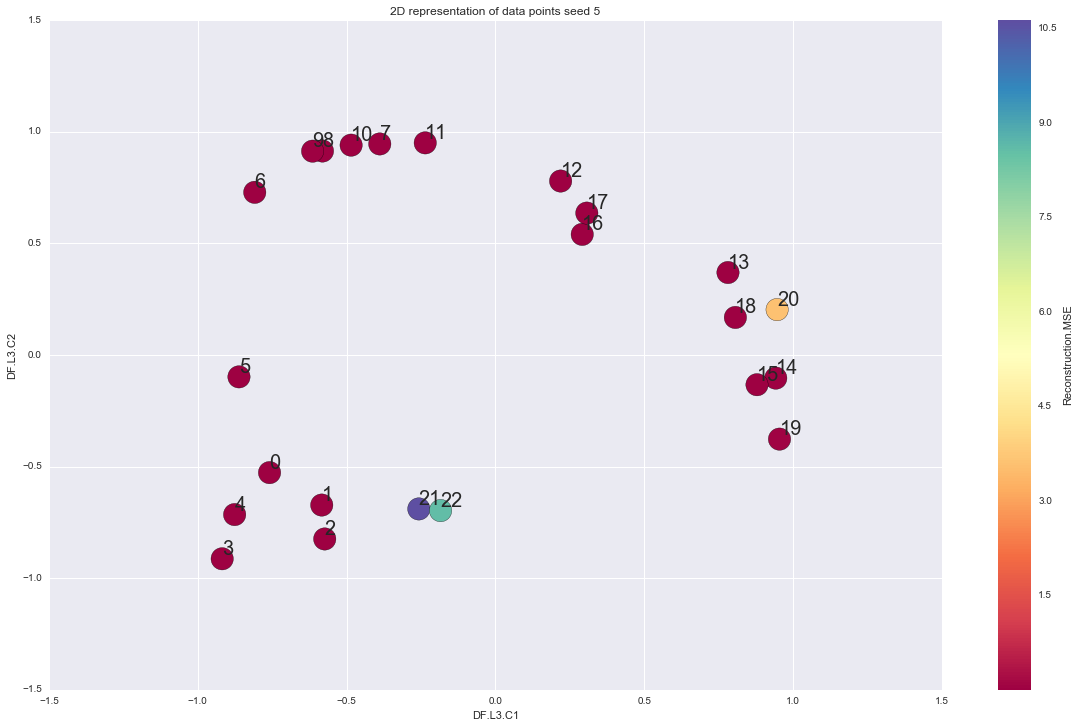

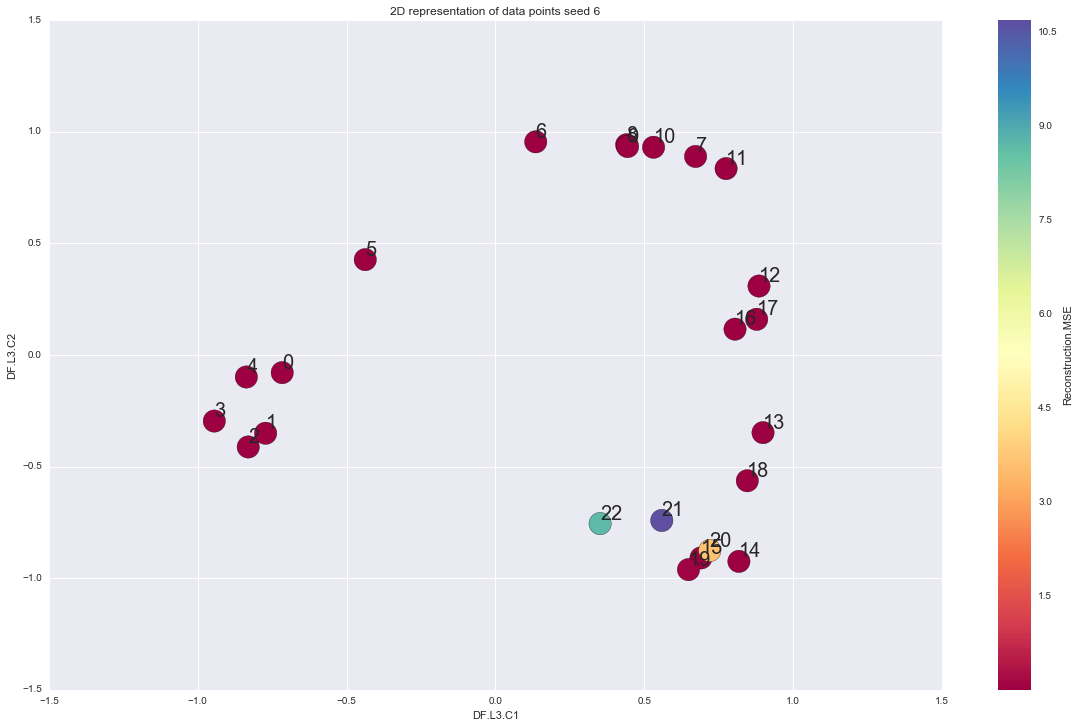

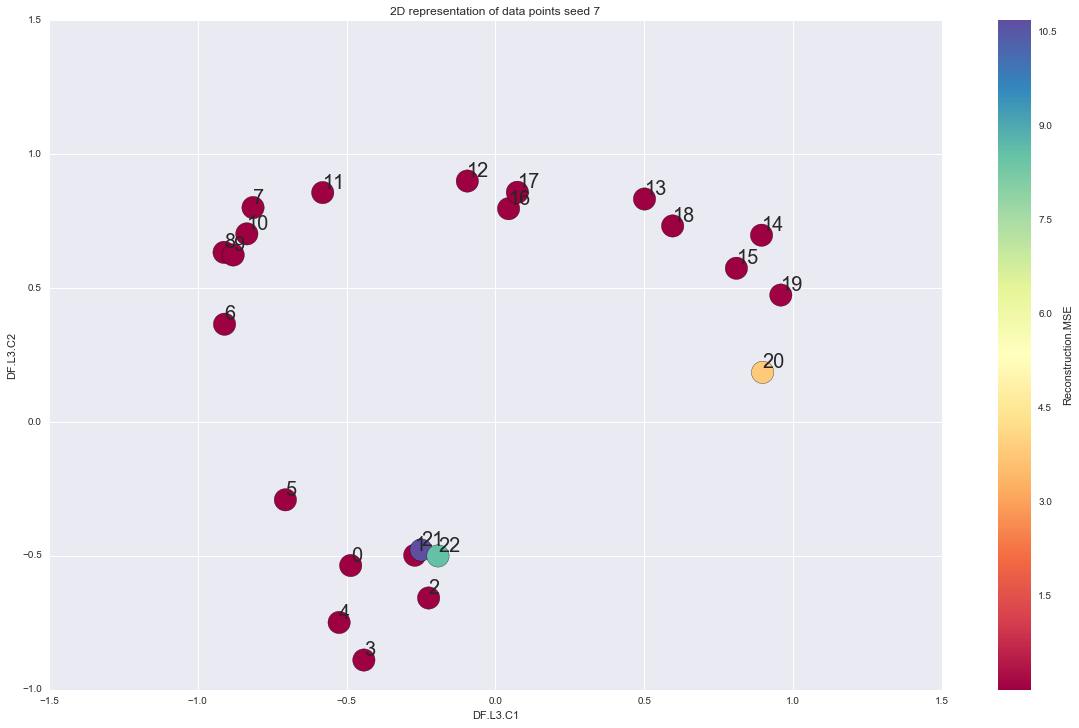

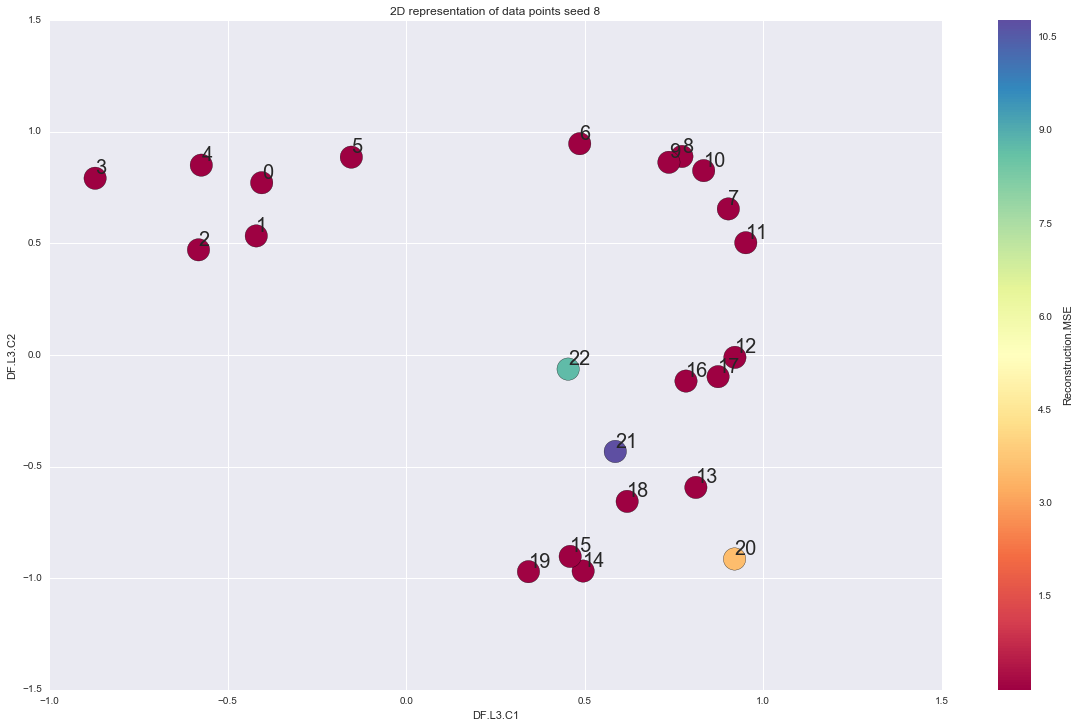

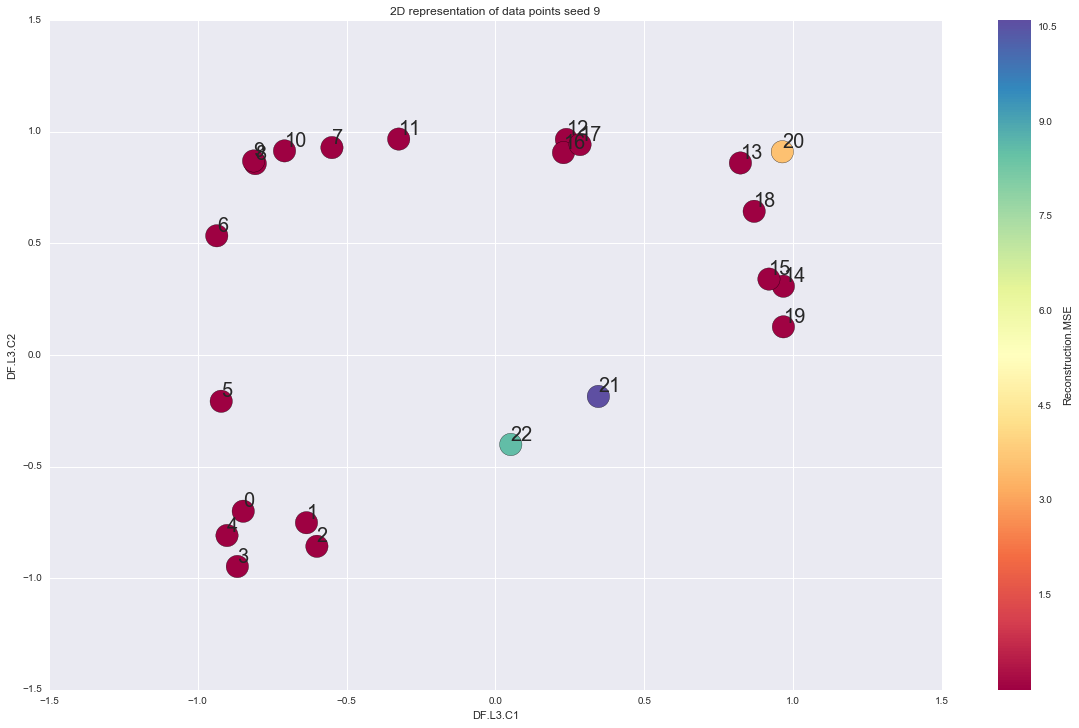

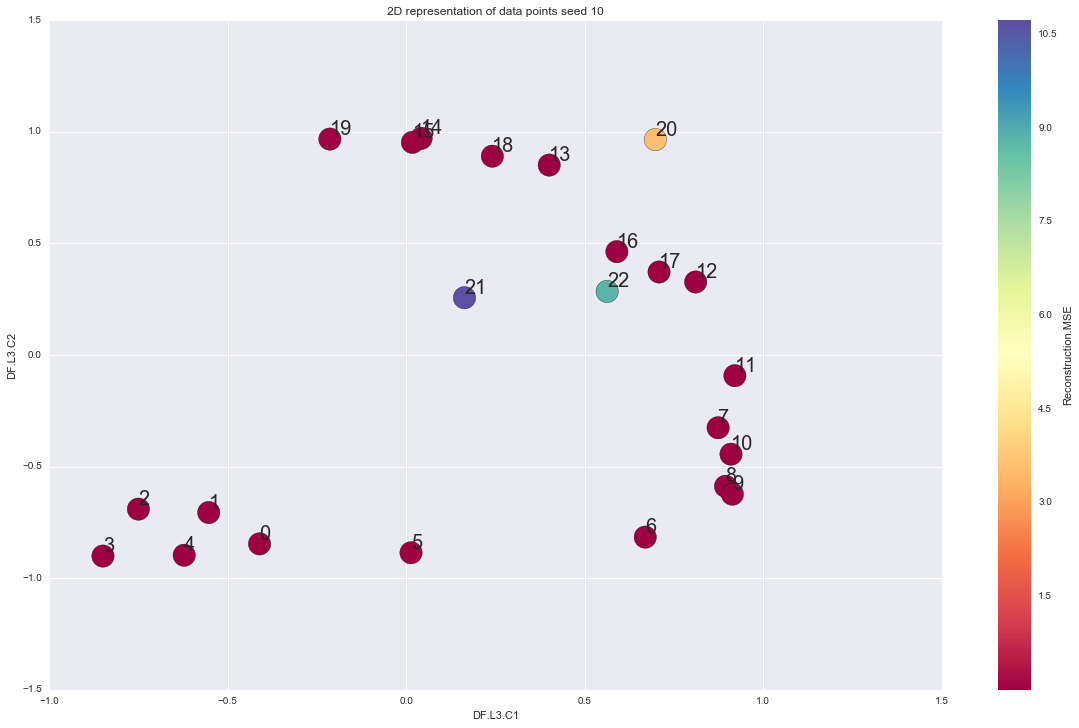

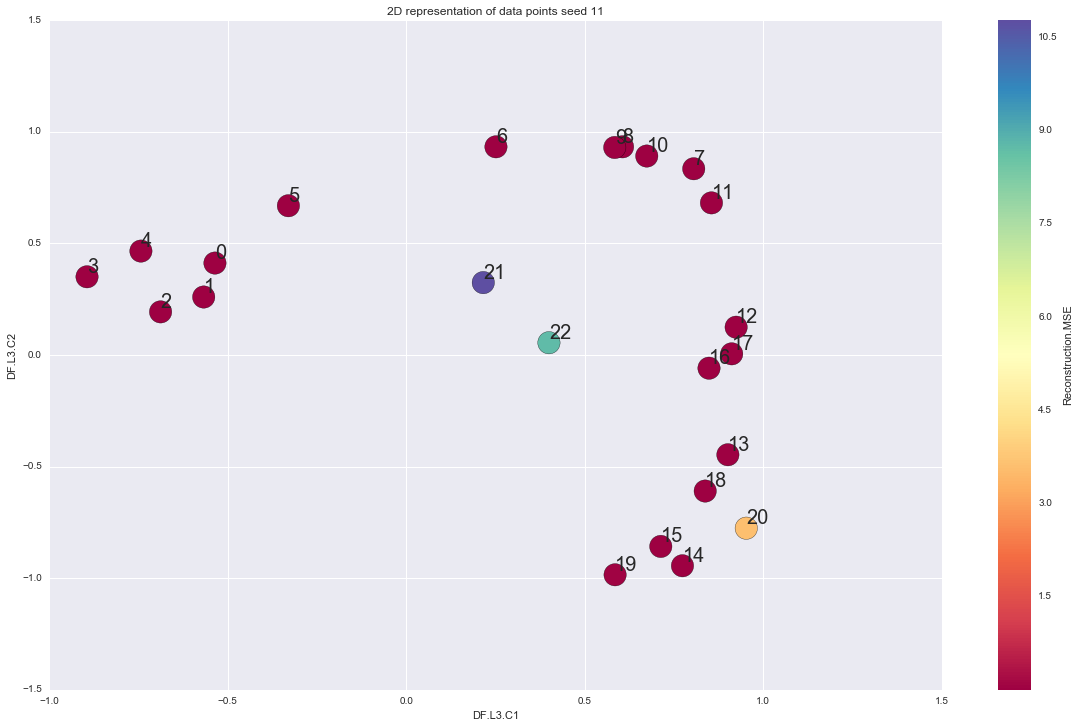

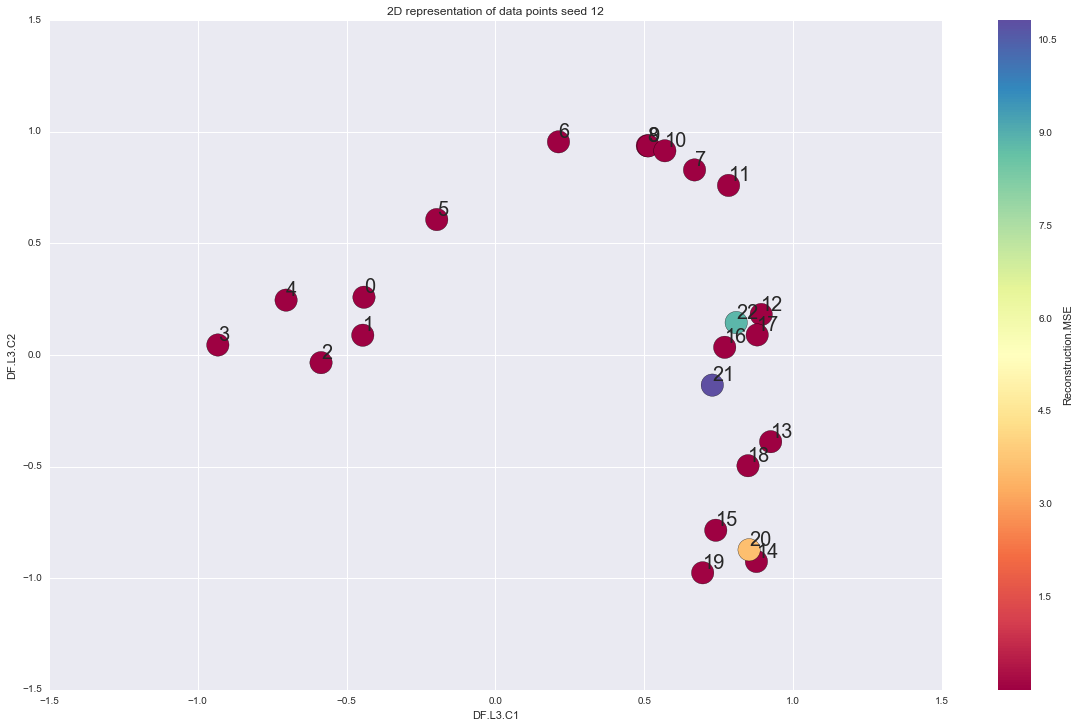

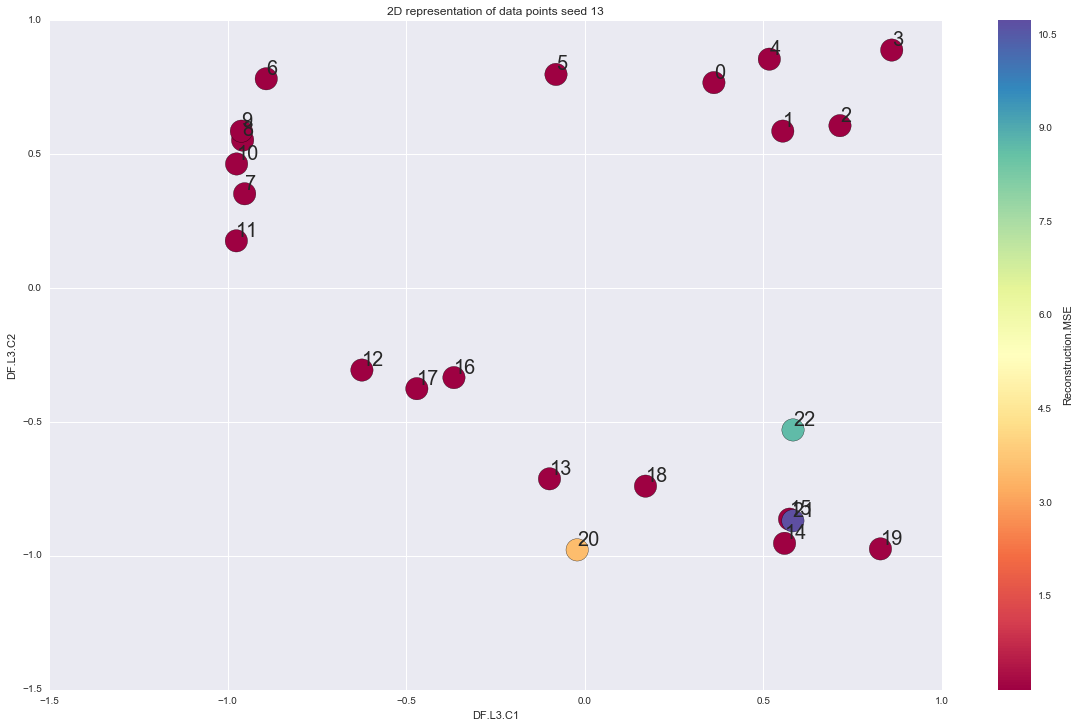

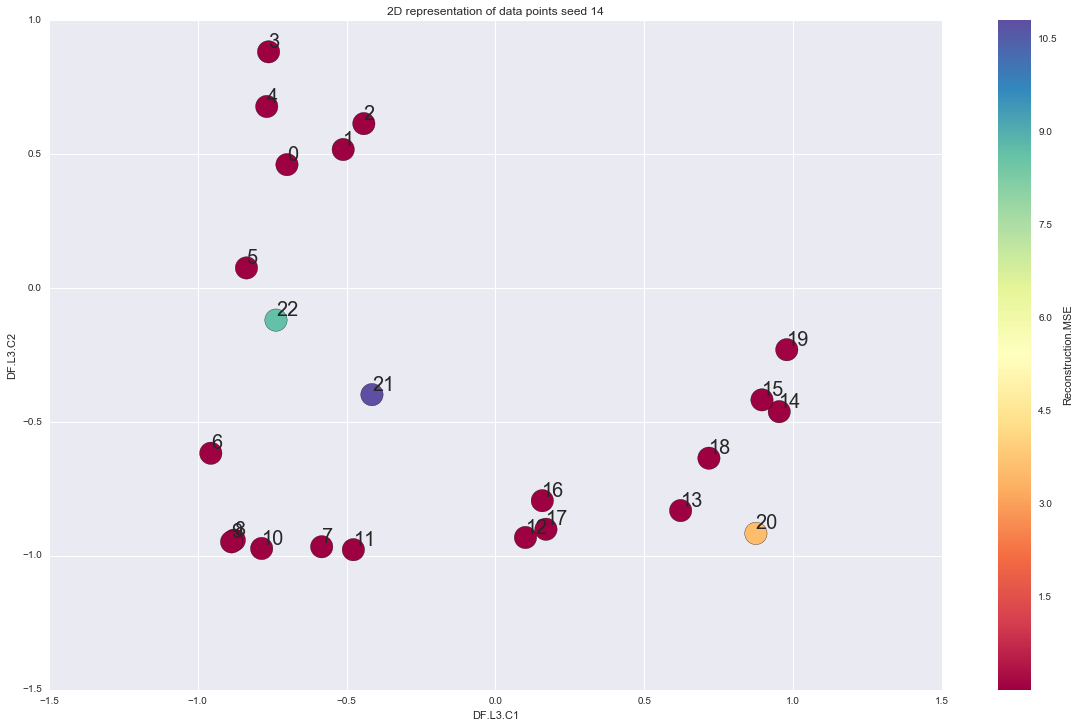

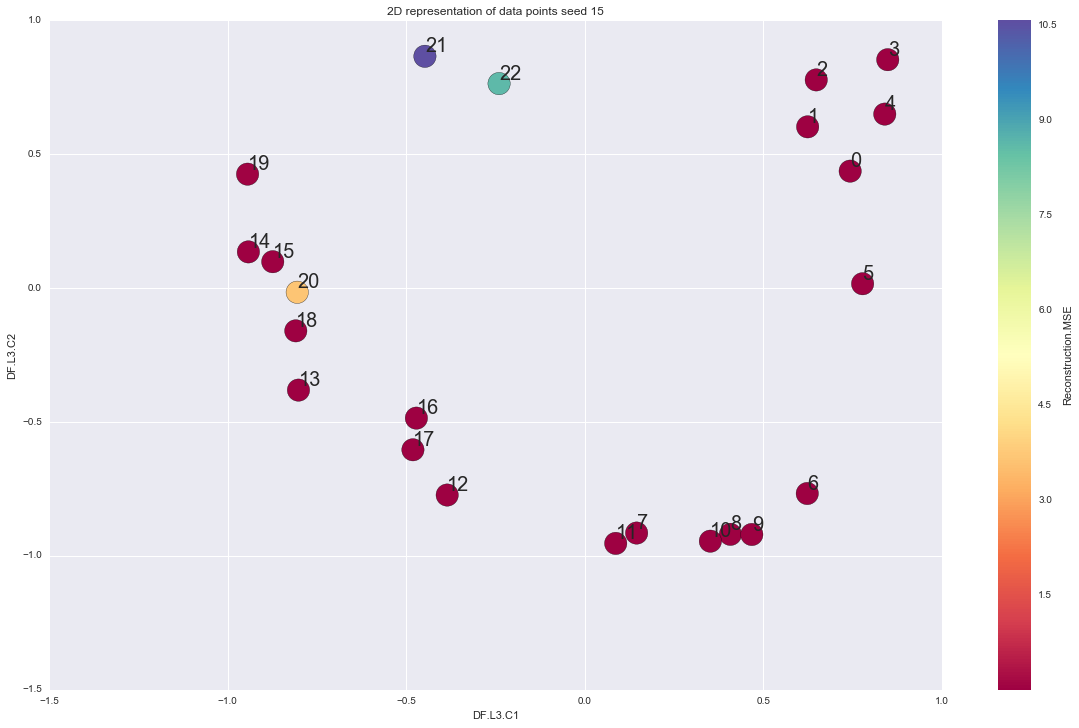

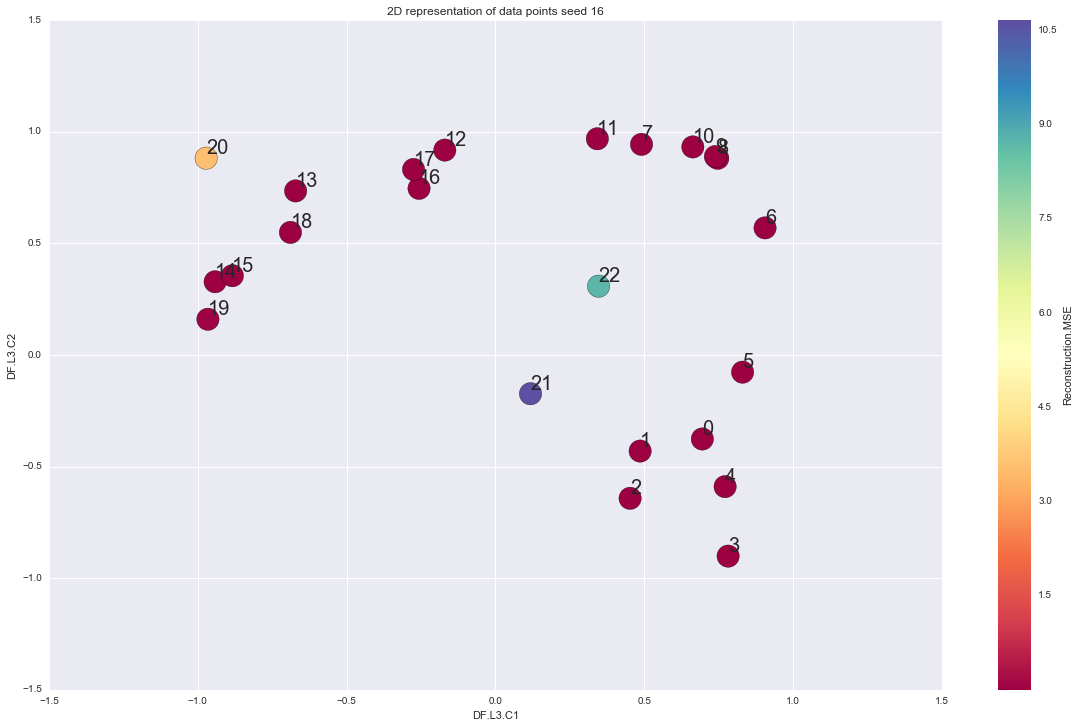

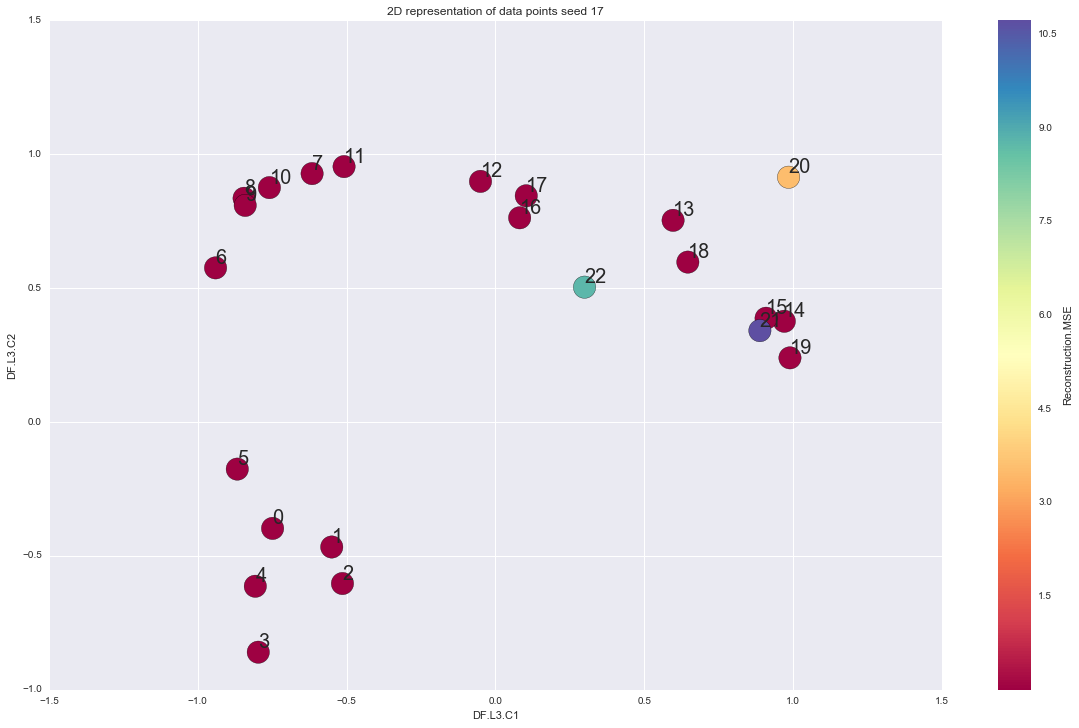

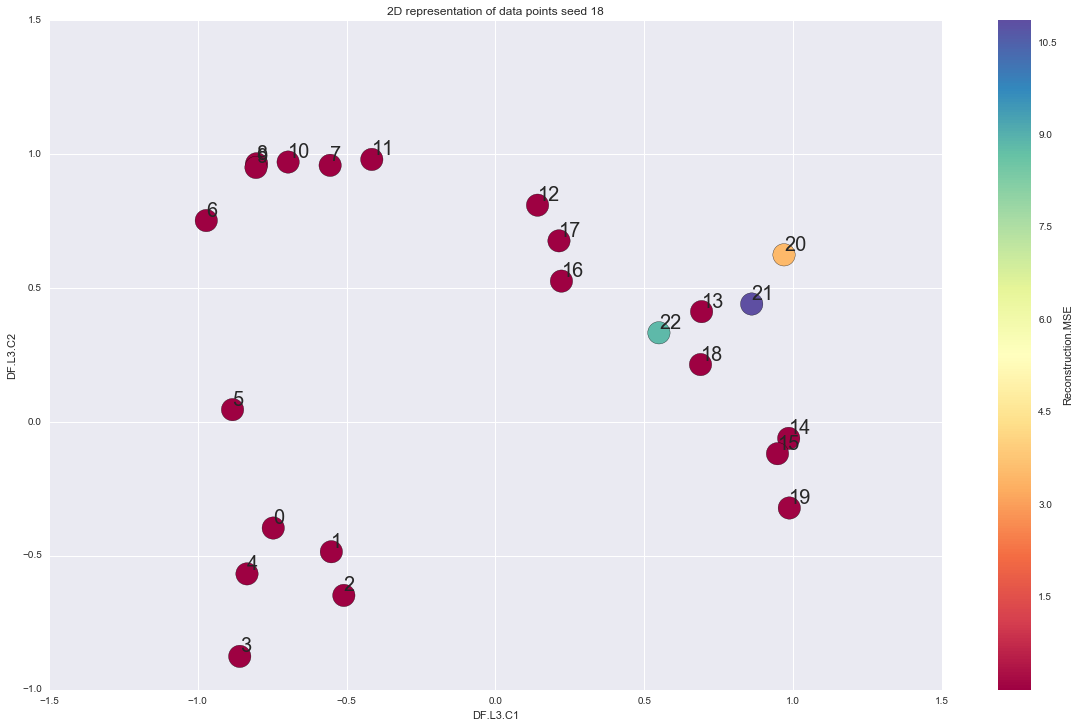

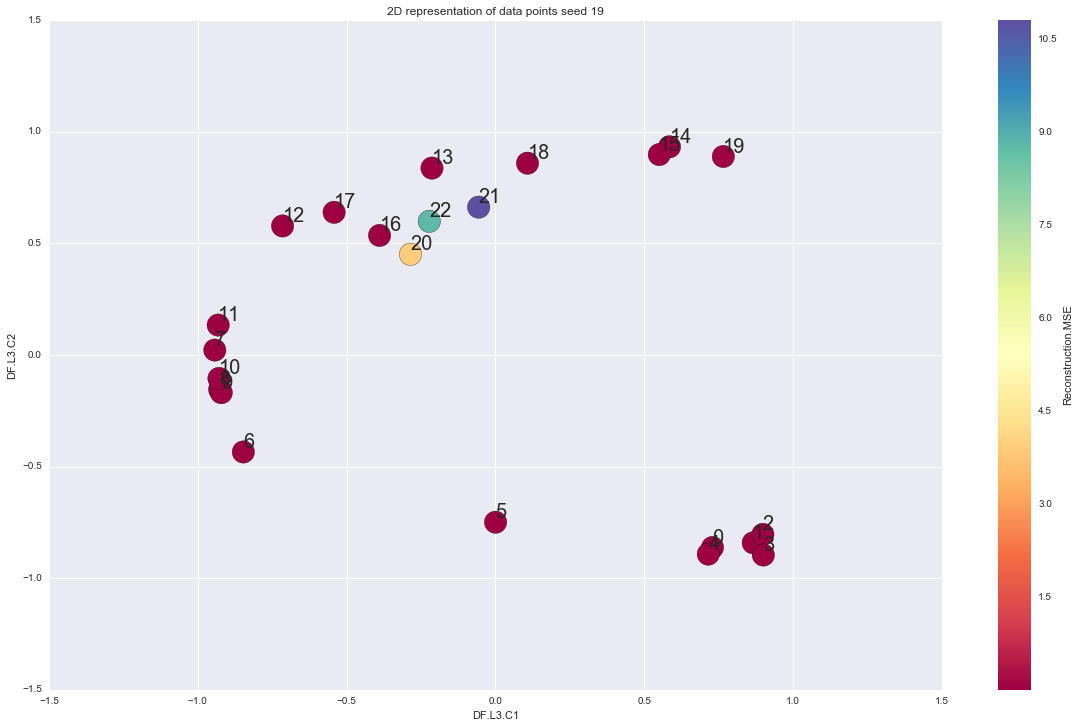

In [134]:
for seed in range(1, 6):
    model = H2OAutoEncoderEstimator(
        activation="Tanh",
        hidden=[50,20, 2, 20, 50],
        epochs=100,
        #sparse=True,
        #l1=1e-5,
        seed=seed,
        reproducible=True)
    model.train(
    x=train_ecg.names,
    training_frame=train_ecg)

    recon_error = model.anomaly(test_ecg)
    plot_bidimensional(model, test_ecg, recon_error, 2, "2D representation of data points seed {}".format(seed))
    # compute average and variance of the 2 dimensions


In [133]:
model = H2OAutoEncoderEstimator(
        activation="Tanh",
        hidden=[50,20, 2, 20, 50],
        epochs=100,
        #sparse=True,
        #l1=1e-5,
        seed=1,
        reproducible=True)
model.train(
    x=train_ecg.names,
    training_frame=train_ecg
)

recon_error = model.anomaly(test_ecg)
bidimensional_data = model.deepfeatures(test_ecg, 2).cbind(recon_error).as_data_frame()
bidimensional_data

deeplearning Model Build progress: |██████████████████████████████████████████████████████████| 100%
deepfeatures progress: |██████████████████████████████████████████████████████████████████████| 100%


,DF.L3.C1,DF.L3.C2,Reconstruction.MSE
0,0.487688,0.863620,0.006362
1,0.635581,0.756164,0.011617
2,0.764004,0.777907,0.008139
3,0.847438,0.879615,0.024230
4,0.653252,0.918426,0.005973
5,0.033087,0.895865,0.014068
6,-0.849062,0.803780,0.021128
7,-0.934323,0.278897,0.008563
8,-0.953484,0.554313,0.015090
9,-0.954942,0.565842,0.016041
